In [42]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["../assets/hubert/hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model
hubert_model.eval()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats):
        # inputs = {
        #     "source": feats,
        #     "padding_mask": padding_mask,
        #     # "padding_mask": None,
        #     "output_layer": 12
        # }
        # return self.model.extract_features(**inputs)
        return self.model(
            source = feats,
            output_layer = 12,
            features_only = True,
            mask = False
        )['x']

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt").float()
padding_mask = torch.load("./padding_mask.pt").float()

/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/checkpoint_utils.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, map_location=

In [43]:
adapter = HuberAdapter(hubert_model.cuda())

In [44]:
output = adapter(feats)

In [45]:
output[0].shape

torch.Size([100, 768])

In [46]:
output[0]

tensor([[-0.1189, -0.0122, -0.1055,  ..., -0.0258,  0.1201, -0.0282],
        [-0.2382, -0.1192, -0.3018,  ..., -0.2731,  0.0824,  0.1034],
        [-0.1458, -0.0125, -0.2260,  ..., -0.2818, -0.0350,  0.0519],
        ...,
        [-0.0834,  0.2034, -0.3241,  ..., -0.0257,  0.3254,  0.0428],
        [-0.1327,  0.2221, -0.0961,  ...,  0.1378,  0.3199,  0.1589],
        [ 0.0546,  0.0265, -0.1794,  ..., -0.0234, -0.0333, -0.1389]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [47]:
output[0].dtype

torch.float32

Before runnning exportation code,i;ve modified fairseq/models/wav2vec/utils.py with below code:
```python
def pad_to_multiple(x, multiple, dim=-1, value=0):
    # Inspired from https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py#L41
    if x is None:
        return None, 0
    tsz = x.size(dim)
    m = tsz / multiple
    remainder = math.ceil(m) * multiple - tsz
    m = float(m) # => If without this,will raise `Tensor object has no attribute is_integer()`
    if m.is_integer():
        return x, 0
    pad_offset = (0,) * (-1 - dim) * 2

    return F.pad(x, (*pad_offset, 0, remainder), value=value), remainder
```

In [48]:
torch.onnx.export(
    adapter.cuda(),
    (feats.cuda()),
    "./ONNX_Models/hubert.onnx",
    input_names=["feats",],
    output_names=["logits",],
    dynamic_axes={
        "feats": {0: "batch", 1: "seq"},
        # "padding_mask": {0: "seq"},
        "logits": {0: "batch", 1: "seq"},
    },
    opset_version=14,
    do_constant_folding=True,
)

/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:16: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  remainder = math.ceil(m) * multiple - tsz
/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:17: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  m = float(m)
/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/modules/multihead_attention.py:506: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

In [49]:
# 读取ONNX
import onnxruntime as ort

model = ort.InferenceSession("./ONNX_Models/hubert.onnx",providers = ["CUDAExecutionProvider"])

model

2025-02-21 21:05:37.120955624 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: /lib/x86_64-linux-gnu/libcudnn_ops.so.9: undefined symbol: _ZN5cudnn5graph13LibraryLoader11getInstanceEv, version libcudnn_graph.so.9

2025-02-21 21:05:37.120993622 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [50]:
r = model.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [51]:
import numpy as np

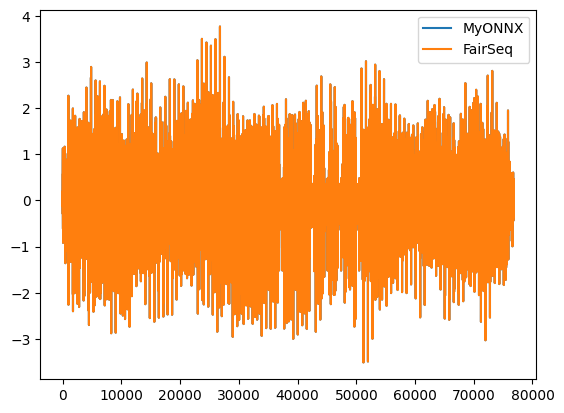

In [52]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()

In [53]:
# 量化
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    "./ONNX_Models/hubert.onnx",
    "./ONNX_Models/hubert_quantized.onnx",
    weight_type = QuantType.QUInt8
)

2025-02-21 21:05:44 | WARNING | root | Please consider to run pre-processing before quantization. Refer to example: https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/ReadMe.md 
2025-02-21 21:05:44 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/Unsqueeze_output_0" not specified
2025-02-21 21:05:44 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.0/conv_layers.0.3/Mul_1_output_0" not specified
2025-02-21 21:05:44 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.1/conv_layers.1.2/Mul_1_output_0" not specified
2025-02-21 21:05:44 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.2/conv_layers.2.2/Mul_1_output_0" not specified
2025-02-21 21:05:44 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.3/conv_layers.3.2/Mul_1_output_0" not specified
2025-0

In [54]:
model_q = ort.InferenceSession("./ONNX_Models/hubert_quantized.onnx",providers = ["CUDAExecutionProvider"])

2025-02-21 21:05:47.535803242 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: /lib/x86_64-linux-gnu/libcudnn_ops.so.9: undefined symbol: _ZN5cudnn5graph13LibraryLoader11getInstanceEv, version libcudnn_graph.so.9

2025-02-21 21:05:47.535844262 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [55]:
r_q = model_q.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [56]:
r_q

array([[[-0.16532245, -0.11758268, -0.01599319, ..., -0.07927404,
          0.1987739 , -0.04471899],
        [-0.07208943, -0.1333815 , -0.44207117, ..., -0.09534323,
          0.0858057 , -0.04291245],
        [ 0.09568284, -0.09500531, -0.29802957, ..., -0.13505538,
          0.11834914,  0.05016929],
        ...,
        [ 0.15760465,  0.11407235,  0.01654378, ..., -0.19009863,
          0.07748672,  0.04045765],
        [ 0.10431526,  0.17101273,  0.15955982, ..., -0.11095127,
          0.08844461, -0.13006032],
        [ 0.06086141, -0.00974517, -0.26613963, ..., -0.04813069,
         -0.0515393 , -0.20390195]]], dtype=float32)

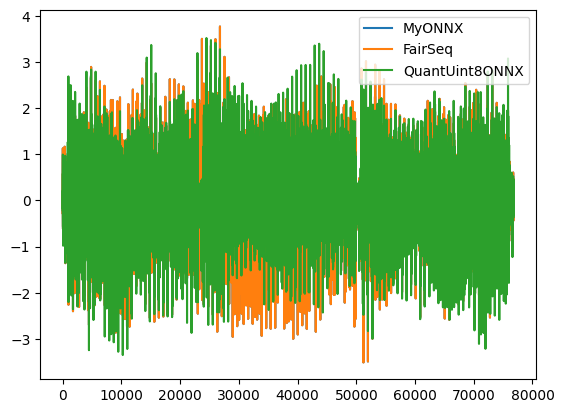

In [57]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.plot(np.array(r_q.flatten()),label="QuantUint8ONNX")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()